# Machine learning model for "predictive autoscaling"

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[20,5]
plt.rcParams['font.size']=15
import seaborn as sb
color_pal=sb.color_palette()
import xgboost as xgb

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing dataset

In [14]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/app.csv',sep=';')
df

,time,users,sessions,newusers,crashes
0,22.12.18 09:00,64,60,5,0
1,22.12.18 10:00,79,84,8,0
2,22.12.18 11:00,97,102,22,0
3,22.12.18 12:00,107,102,13,0
4,22.12.18 13:00,105,117,10,2
...,...,...,...,...,...
164,29.12.18 05:00,40,34,6,0
165,29.12.18 06:00,48,41,8,0
166,29.12.18 07:00,44,37,3,0
167,29.12.18 08:00,38,40,1,0


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Indexing using datetime

In [16]:
df['time'] = pd.to_datetime(df['time'])
print(df.dtypes)

time        datetime64[ns]
users                int64
sessions             int64
newusers             int64
crashes              int64
dtype: object


In [17]:
df=df.set_index('time')
df.index=pd.to_datetime(df.index)
df

,users,sessions,newusers,crashes
time,,,,
2018-12-22 09:00:00,64,60,5,0
2018-12-22 10:00:00,79,84,8,0
2018-12-22 11:00:00,97,102,22,0
2018-12-22 12:00:00,107,102,13,0
2018-12-22 13:00:00,105,117,10,2
...,...,...,...,...
2018-12-29 05:00:00,40,34,6,0
2018-12-29 06:00:00,48,41,8,0
2018-12-29 07:00:00,44,37,3,0


## User Stats per day

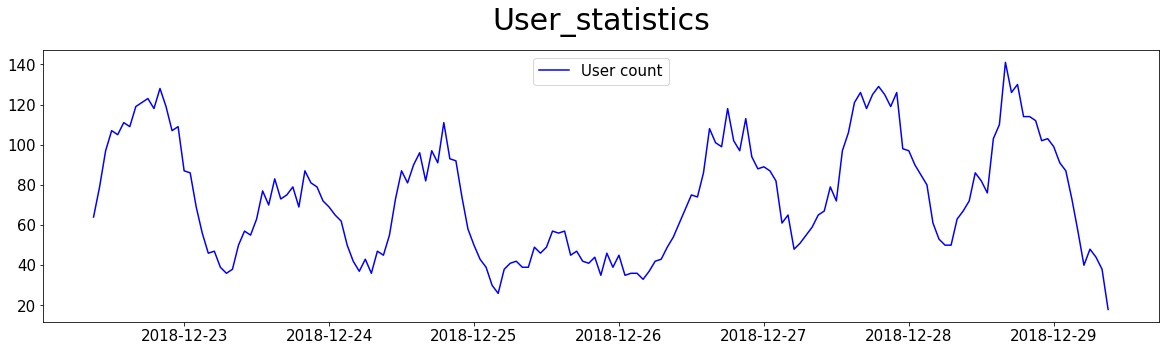

In [18]:

plt.title("User_statistics",pad=20,fontsize=30)
plt.plot(df['users'], color='blue',label='User count')
plt.legend(loc='upper center');

## Stationary test for time-series 
>#### Within timeseries analysis, stationary means that the properties of the timeseries such as mean and variance remain constant over time. 
 
>#### In case mean and variance are increasing or decreasing over time we speak of a trend.

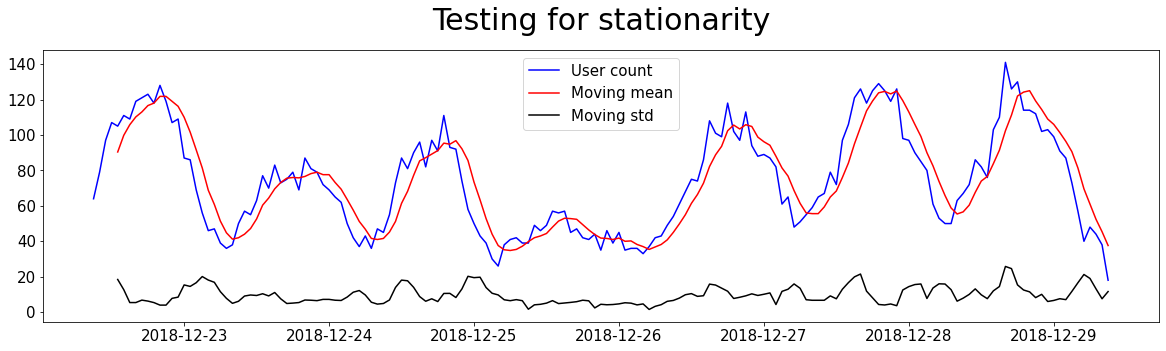

In [19]:
moving_mean = df['users'].rolling(5).mean()
moving_std = df['users'].rolling(5).std()
plt.title("Testing for stationarity",pad=20,fontsize=30)
plt.plot(df['users'], color='blue',label='User count')
plt.plot(moving_mean, color='red', label='Moving mean')
plt.plot(moving_std, color='black', label = 'Moving std')
plt.legend(loc='upper center');

#### The result of the test is interpreted through the tests p-value. A p-value below 5% or 1% means that we can reject the null hypothesis (stationary), otherwise a p-value above means we fail to reject the null hypothesis (non-stationary).

>#### p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
>#### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [20]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['users'].values)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -4.423338
p-value                          0.000270
#Lags Used                       5.000000
Number of Observations Used    163.000000
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
Critical Value (10%)            -2.576314
dtype: float64


#### Our example timeseries has a p-value of 0.00027% that allows us to reject the Null Hypothesis, it is clearly stationary and shows no trend. 

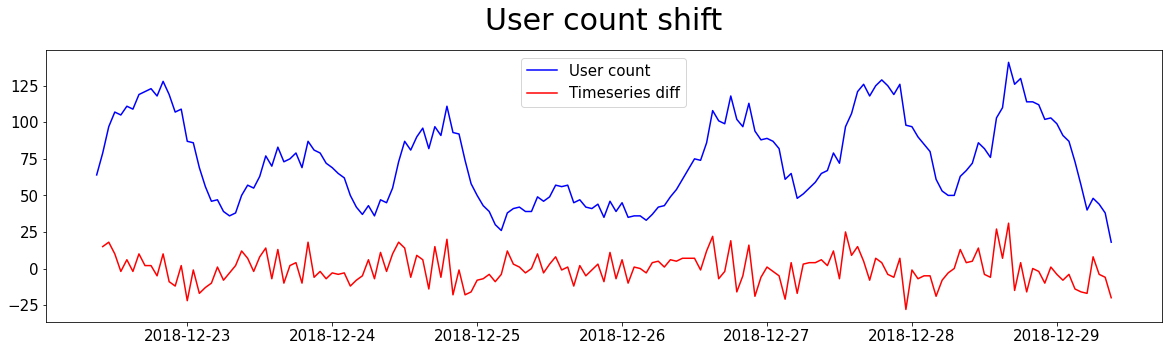

In [21]:
ts_diff = df['users'] - df['users'].shift()
plt.title("User count shift",pad=20,fontsize=30)
plt.plot(df['users'], color='blue',label='User count')
plt.plot(ts_diff, color='red', label='Timeseries diff')
plt.legend(loc='upper center');

#### Subtract the original ts by its shifted value over time.

## Decomposing
>#### A decomposing step models the trend, seasonality as well as residuals individually.

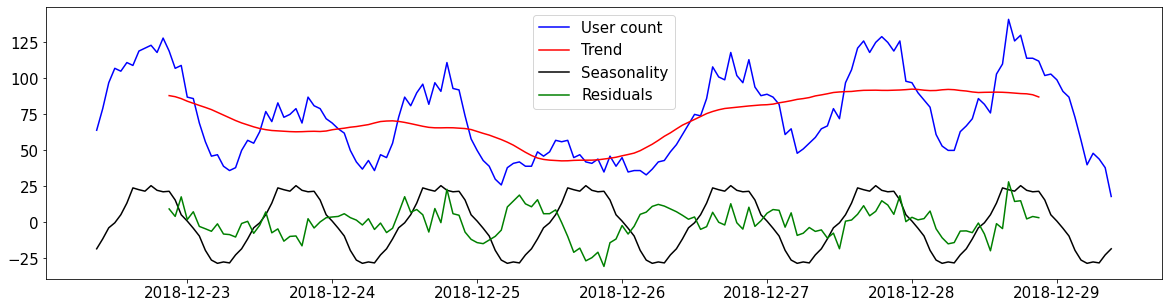

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['users'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.plot(df['users'], color='blue',label='User count')
plt.plot(trend, color='red', label='Trend')
plt.plot(seasonal, color='black', label='Seasonality')
plt.plot(residual, color='green', label='Residuals')
plt.legend(loc='upper center');

## Forecasting a timeseries
>#### Now that we have extracted the essential residual timeseries by removing seasonality and trend aspects, we can start to predict the timeseries into the future.

### Model 1------------------------------------------------------------------------------------
#### Moving Average (MA)
#### This forcast method models the next steps within the predicted timeseries through a mean process of historic measurements.

In [23]:

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df.users, order=(1,0,0))

model_fit = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [24]:
# make prediction
ma_pred_users = model_fit.predict(68, 168)
ma_pred_users

2018-12-25 05:00:00    28.544818
2018-12-25 06:00:00    39.833274
2018-12-25 07:00:00    42.655388
2018-12-25 08:00:00    43.596092
2018-12-25 09:00:00    40.773978
                         ...    
2018-12-29 05:00:00    57.706663
2018-12-29 06:00:00    41.714683
2018-12-29 07:00:00    49.240320
2018-12-29 08:00:00    45.477502
2018-12-29 09:00:00    39.833274
Freq: H, Name: predicted_mean, Length: 101, dtype: float64

### Future predictions

In [25]:
ma_fpred_users = model_fit.predict(100, 200)
ma_fpred_users

2018-12-26 13:00:00     74.639347
2018-12-26 14:00:00     73.698642
2018-12-26 15:00:00     84.987098
2018-12-26 16:00:00    105.682601
2018-12-26 17:00:00     99.097668
                          ...    
2018-12-30 13:00:00     59.722480
2018-12-30 14:00:00     60.267712
2018-12-30 15:00:00     60.780615
2018-12-30 16:00:00     61.263104
2018-12-30 17:00:00     61.716985
Freq: H, Name: predicted_mean, Length: 101, dtype: float64

### Ploting future user count

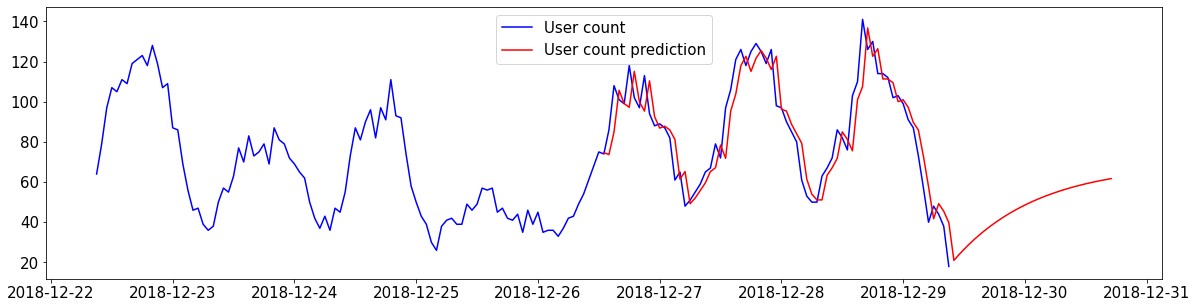

In [26]:
plt.plot(df['users'], color='blue',label='User count')
plt.plot(ma_fpred_users, color='red',label='User count prediction')
plt.legend(loc='upper center');

### Model 2---------------------------------------------------------------------------------------------
#### Prediction with Autoregression (AutoReg)
#### This method models the next step in the sequence as a linear function of the observations at prior time steps 

In [27]:
from statsmodels.tsa.ar_model import AutoReg

# fit model
model = AutoReg(df['users'],lags=5)
model_fit = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [28]:
pred_users = model_fit.predict(68, 168)
pred_users

2018-12-25 05:00:00    26.458182
2018-12-25 06:00:00    37.004878
2018-12-25 07:00:00    46.446102
2018-12-25 08:00:00    49.152443
2018-12-25 09:00:00    45.297949
                         ...    
2018-12-29 05:00:00    52.601794
2018-12-29 06:00:00    34.665665
2018-12-29 07:00:00    38.571265
2018-12-29 08:00:00    43.796060
2018-12-29 09:00:00    41.051762
Freq: H, Length: 101, dtype: float64

### Future predictions

In [29]:
# make prediction
fpred_users = model_fit.predict(100, 200)
fpred_users

2018-12-26 13:00:00     79.045433
2018-12-26 14:00:00     78.762424
2018-12-26 15:00:00     85.970695
2018-12-26 16:00:00    107.290188
2018-12-26 17:00:00    108.606837
                          ...    
2018-12-30 13:00:00     69.984192
2018-12-30 14:00:00     69.167007
2018-12-30 15:00:00     68.569372
2018-12-30 16:00:00     68.181578
2018-12-30 17:00:00     67.986016
Freq: H, Length: 101, dtype: float64

### Ploting future user count

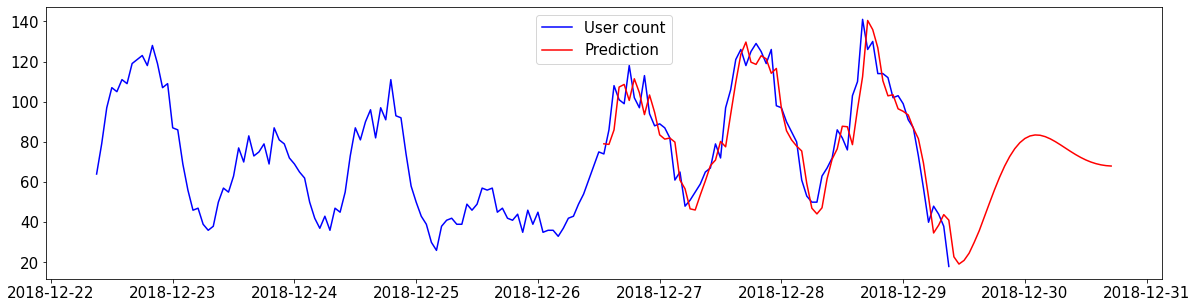

In [30]:
plt.plot(df['users'], color='blue',label='User count')
plt.plot(fpred_users, color='red', label='Prediction')
plt.legend(loc='upper center');

In [31]:
actual=df.drop(df.index[0:68])
actual

,users,sessions,newusers,crashes
time,,,,
2018-12-25 05:00:00,38,37,2,0
2018-12-25 06:00:00,41,42,7,0
2018-12-25 07:00:00,42,38,5,0
2018-12-25 08:00:00,39,45,4,0
2018-12-25 09:00:00,39,31,3,0
...,...,...,...,...
2018-12-29 05:00:00,40,34,6,0
2018-12-29 06:00:00,48,41,8,0
2018-12-29 07:00:00,44,37,3,0


### MODEL EVALUATION

#### RMS ERROR: MOVING AVERAGE MODEL

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(actual['users'],pred_users))
print(rmse)

9.547217291686088


#### RMS ERROR: ARIMA MODEL

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(actual['users'],ma_pred_users))
print(rmse)

10.239019867303917
